In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = transforms.Compose([
                transforms.RandomResizedCrop(256),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)      
])

In [52]:
train_dir = 'dataset2/training_set/'
test_dir   = 'dataset2/test_set/'
train_dataset = datasets.ImageFolder(train_dir,data_transforms)
train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)

test_dataset = datasets.ImageFolder(test_dir,data_transforms)
test_loader = DataLoader(test_dataset,batch_size=4,shuffle=True)

print(f'Size of train_dataset = {len(train_dataset)}')
print(f'Size of test_dataset = {len(test_dataset)}')

Size of train_dataset = 8000
Size of test_dataset = 2000


In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


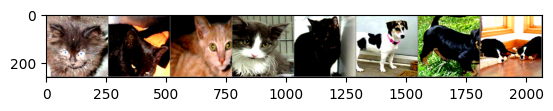

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


In [38]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Training phase
        model.train()
        running_loss = 0
        running_corrects =0

        # Iterate over data.
        for idx,(inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # print(outputs)
            _,predictions = torch.max(outputs,1)
            # print(predictions)
            loss = criterion(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(predictions == labels.data)

            if (idx+1) % 100 == 0:
                print (f'Epoch [{epoch+1}/{num_epochs}], Step [{idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        scheduler.step()
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)
        
        print (f'Epoch [{epoch+1}/{num_epochs}], Accuracy : {epoch_acc}, Best Accuracy: {best_acc}')


        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print('Finished Training')
    model.load_state_dict(best_model_wts)
    PATH = './dcModel.pth'
    torch.save(model.state_dict(), PATH)

    return model

In [43]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [44]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch [1/25], Step [100/2000], Loss: 0.6724
Epoch [1/25], Step [200/2000], Loss: 0.6500
Epoch [1/25], Step [300/2000], Loss: 0.6562
Epoch [1/25], Step [400/2000], Loss: 0.8434
Epoch [1/25], Step [500/2000], Loss: 0.5410
Epoch [1/25], Step [600/2000], Loss: 0.5059
Epoch [1/25], Step [700/2000], Loss: 0.7194
Epoch [1/25], Step [800/2000], Loss: 0.4523
Epoch [1/25], Step [900/2000], Loss: 0.3597
Epoch [1/25], Step [1000/2000], Loss: 0.4551
Epoch [1/25], Step [1100/2000], Loss: 0.4427
Epoch [1/25], Step [1200/2000], Loss: 0.3962
Epoch [1/25], Step [1300/2000], Loss: 0.3633
Epoch [1/25], Step [1400/2000], Loss: 0.7313
Epoch [1/25], Step [1500/2000], Loss: 0.3718
Epoch [1/25], Step [1600/2000], Loss: 0.8083
Epoch [1/25], Step [1700/2000], Loss: 0.2377
Epoch [1/25], Step [1800/2000], Loss: 0.3862
Epoch [1/25], Step [1900/2000], Loss: 0.4504
Epoch [1/25], Step [2000/2000], Loss: 0.4475
Epoch [1/25], Accuracy : 0.776625, Best Accuracy: 0.0
Epoch [2/25], Step [100/2000], Loss: 0.5925
Epoch [2/25

KeyboardInterrupt: 

## Performace on test dataset

In [71]:
def evaluate(model):
    model = model.to(device)
    model.eval()
    running_corrects = 0
    with torch.no_grad():
    
        for idx,(inputs,labels) in enumerate(test_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _,predictions = torch.max(outputs,1)
            running_corrects += torch.sum(predictions == labels.data)
            # print(idx,running_corrects)

    model_acc = running_corrects/len(test_dataset)
    print(f'Accuracy: {model_acc}')
    return


In [72]:
PATH = 'dcModel_89%.pth'
model.load_state_dict(torch.load(PATH))
evaluate(model)

Accuracy: 0.9670000672340393


: 

500